# Mechanisms of Action (MoA) Prediction - 0 Label Classifier
## Train

In this notebook, instead of training a model to predict the outcomes of the competition, we'll train a classifier to predict records that have no labels. If effective, this kind of model could be used as part of multiple solutions. 

For example, it could be used as a meta-classifier, where we create a new feature that we feed into the next model (either as a stacked solution, or a binary feature alongside the original data). Also, it could be used as part of the model ensembling stage, where we can invert the prediction values (so a zero-label record is denoted with a 0) and apply any model weighting where necessary. This would bring probabilities down for each record at a level depending on the model weighting. Furthermore, we could even replace the prediction of any record predicted to have no label with a 0 for each label. These possible solutions all increase in size of effect it would have on the final predictions, and it will require some evaluation to decide where to set threshold of how much importance we will give these models.

We begin by defining a baseline model, with attributing data transformation functions (so all transformations can be done in-fold, avoiding any data leakage occurring). We then dispose of this baseline model, but keep the basic format, when conducting Bayesian Hyperparameter search to find the best parameters. This step will change the architecture of the model at each fold, so will potentially result in differing model architectures for all 10 folds.


## 1.00 Import Packages

In [1]:
# General packages
import pandas as pd
import numpy as np
import os
import gc
import random
from tqdm import tqdm, tqdm_notebook

import time
import warnings
warnings.filterwarnings('ignore')

# Data vis packages
import matplotlib.pyplot as plt
%matplotlib inline

# Data prep
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

# Modelling packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as k
# Key layers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Add, Dense, Flatten
# Activation layers
from tensorflow.keras.layers import ReLU, LeakyReLU, ELU, ThresholdedReLU
# Dropout layers
from tensorflow.keras.layers import Dropout, AlphaDropout, GaussianDropout
# Normalisation layers
from tensorflow.keras.layers import BatchNormalization
# Embedding layers
from tensorflow.keras.layers import Embedding, Concatenate, Reshape
# Callbacks
from tensorflow.keras.callbacks import Callback, EarlyStopping, LearningRateScheduler, ModelCheckpoint
# Optimisers
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adadelta, Adagrad, Adamax, Nadam, Ftrl
# Model cross validation and evaluation
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

# For Bayesian hyperparameter searching
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

strategy = tf.distribute.get_strategy()
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

# Data access
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)

Num GPUs Available:  1
REPLICAS: 1


## 2.00 Read in Data

In [3]:
# Directory and file paths
input_dir                 = '../input/lish-moa/'
train_features_path       = os.path.join(input_dir, 'train_features.csv')
test_features_path        = os.path.join(input_dir, 'test_features.csv')
train_targets_scored_path = os.path.join(input_dir, 'train_targets_scored.csv')
sample_submission_path    = os.path.join(input_dir, 'sample_submission.csv')

# Read in data
train_features       = pd.read_csv(train_features_path)
test_features        = pd.read_csv(test_features_path)
train_targets_scored = pd.read_csv(train_targets_scored_path)
sample_submission    = pd.read_csv(sample_submission_path)

del train_features_path, test_features_path, train_targets_scored_path, sample_submission_path

print(f'train_features shape: \t\t{train_features.shape}')
print(f'test_features shape: \t\t{test_features.shape}')
print(f'train_targets_scored shape: \t{train_targets_scored.shape}')
print(f'sample_submission shape: \t{sample_submission.shape}')

train_features shape: 		(23814, 876)
test_features shape: 		(3982, 876)
train_targets_scored shape: 	(23814, 207)
sample_submission shape: 	(3982, 207)


In [4]:
# Define key parameters
SEED = 28
np.random.seed(SEED)

SCALER_METHOD = RobustScaler()

FEATURE_SELECTOR = RandomForestClassifier(random_state=SEED)

NUM_COMPONENTS = 200
PCA_METHOD = PCA(n_components=NUM_COMPONENTS, random_state=SEED)

EPOCHS = 100
BATCH_SIZE = 64
KFOLDS = 10
PATIENCE = 10

USE_EMBEDDING = True
MODEL_TO_USE = 'nn'
model_name_save = MODEL_TO_USE + '_0_label_classifier_seed' + str(SEED)

# Create weights path if does not exist already
if not os.path.exists(f'weights/{model_name_save}'):
    os.mkdir(f'weights/{model_name_save}')

print(f'Model name: {model_name_save}')

Model name: nn_0_label_classifier_seed28


## 3.00 Data Preparation

In [5]:
def transform_target_data(data):
    """
    Transforms the target dataset with multiple labels into 
    a dataset that has one label (indicating whether there were
    0 labels or not)
    """
    # Get number of labels per sig_id
    data_transformed = data.drop('sig_id', axis=1).sum(axis=1)
    data_transformed = pd.DataFrame(data_transformed).rename(columns={0:'num_labels'})
    # Add labels based on whether there are zero labels or not
    data_transformed['has_zero_label'] = 0
    data_transformed.loc[data_transformed.num_labels == 0, 'has_zero_label'] = 1
    # Remove num_labels feature for final target df
    data_transformed = data_transformed.drop('num_labels', axis=1)
    
    return data_transformed

In [6]:
def transform_feature_set(X_train, X_test, y_train, y_test, 
                          verbose=0, 
                          scaler=SCALER_METHOD, 
                          feature_selector=FEATURE_SELECTOR, 
                          pca=PCA_METHOD, 
                          seed=SEED):
    """
    Takes in X_train and X_test datasets, and applies feature selection, scaling and pca
    depending on arguments. 
    
    Returns X_train and X_test data ready for training/prediction, and returns
    list of numerical cols and categorical cols, for the use of creating embeddings.
    """
    
    ## DATA PREPARATION ##
    
    # Drop unique ID feature
    X_train = X_train.drop('sig_id', axis=1)
    X_test  = X_test.drop('sig_id', axis=1)
    # Get indices for train and test dfs - we'll need these later
    train_idx = list(X_train.index)
    test_idx  = list(X_test.index)
    # Separate train data types
    X_train_numerical   = X_train.select_dtypes('number')
    X_train_categorical = X_train.select_dtypes('object')
    X_train_categorical = X_train_categorical.astype('category')
    # Separate val data types
    X_test_numerical   = X_test.select_dtypes('number')
    X_test_categorical = X_test.select_dtypes('object')
    X_test_categorical = X_test_categorical.astype('category')
    
    
    ## SCALING ##
    
    if scaler is not None:
        if verbose == 1:
            print('APPLYING SCALER...')
        # Fit and transform scaler to train and val
        scaler.fit(X_train_numerical)
        X_train_numerical = scaler.transform(X_train_numerical)
        X_test_numerical  = scaler.transform(X_test_numerical)
    
    
    ## FEATURE SELECTION ##
    
    # Feature selection is only ran on numerical data
    if feature_selector is not None:
        if verbose == 1:
            print('APPLYING FEATURE SELECTOR...')
        # Fit tree based classifier to select features
        if verbose == 1: 
            num_cols = X_train_numerical.shape[1]
        feature_selector  = SelectFromModel(estimator=feature_selector).fit(X_train_numerical, y_train)
        X_train_numerical = feature_selector.transform(X_train_numerical)
        X_test_numerical  = feature_selector.transform(X_test_numerical)
        if verbose == 1: 
            print(f'{num_cols - X_train_numerical.shape[1]} features removed in feature selection.')
            del num_cols

    
    ## PCA ##
    
    if pca is not None:
        if verbose == 1:
            print('APPLYING PCA...')
        # Fit and transform pca to train and val
        pca.fit(X_train_numerical)
        X_train_numerical = pca.transform(X_train_numerical)
        X_test_numerical  = pca.transform(X_test_numerical)
        if verbose == 1:
            print(f'NUMBER OF PRINCIPAL COMPONENTS: {pca.n_components_}')
    # Convert numerical features into pandas dataframe
    X_train_numerical = pd.DataFrame(X_train_numerical, index=train_idx).add_prefix('pca_')
    X_test_numerical  = pd.DataFrame(X_test_numerical, index=test_idx).add_prefix('pca_')
    
    
    ## CATEGORICAL FEATURES ##
    
    # Get categorical and numerical column names
    num_cols = X_train_numerical.columns
    cat_cols = X_train_categorical.columns
    # Encode categorical features
    X_train_categorical = X_train_categorical.apply(lambda x: x.cat.codes)
    X_test_categorical  = X_test_categorical.apply(lambda x: x.cat.codes)

    
    # Concatenate transformed categorical features with transformed numerical features  
    X_train = pd.concat([X_train_categorical, X_train_numerical], axis=1)
    X_test = pd.concat([X_test_categorical, X_test_numerical], axis=1)
    
    if verbose == 1:
        print(f'TRAIN SHAPE: \t{X_train.shape}')
        print(f'VALIDATION SHAPE: \t{X_test.shape}')
    
    return X_train, X_test, num_cols, cat_cols

In [7]:
X = train_features
y = transform_target_data(train_targets_scored)

## 4.00 Modelling
### 4.01 Class Weighting

In [8]:
# Due to the high data imbalance, we add extra weight to the target class
neg, pos = np.bincount(np.array(y['has_zero_label']))

weight_for_0 = (1 / neg)*(len(np.array(y['has_zero_label']))) / 2.0 
weight_for_1 = (1 / pos)*(len(np.array(y['has_zero_label']))) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.82
Weight for class 1: 1.27


### 4.02 Learning Scheduler

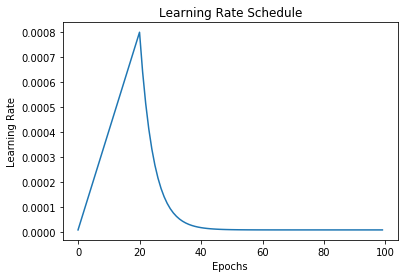

In [9]:
def build_lrfn(lr_start          = 0.00001, 
               lr_max            = 0.0008, 
               lr_min            = 0.00001, 
               lr_rampup_epochs  = 20, 
               lr_sustain_epochs = 0, 
               lr_exp_decay      = 0.8):
    
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr

    return lrfn

lrfn = build_lrfn()
lr = LearningRateScheduler(lrfn, verbose=0)

plt.plot([lrfn(epoch) for epoch in range(EPOCHS)])
plt.title('Learning Rate Schedule')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.show()

### 4.03 Define Model

The below model was the original architecture, however when we conduct our Bayesian Hyperparameter search, we'll be playing around with the architecture of this baseline model a little. Parameter tuning will affect the model depth as well as the numbers of nodes at each layer, the dropout layers, activation functions and optimisers.

In [10]:
def get_model(X_data, numerical_cols, categorical_cols, use_embedding=USE_EMBEDDING):
    
    if use_embedding == True:
        inputs = []
        embeddings = []

        for col in categorical_cols:
            # Create categorical embedding
            input_ = Input(shape=(1,))
            input_dim = int(X_data[col].max() + 1)
            embedding = Embedding(input_dim=input_dim, output_dim=10, input_length=1)(input_)
            embedding = Reshape(target_shape=(10,))(embedding)
            inputs.append(input_)
            embeddings.append(embedding)

        input_numeric = Input(shape=(len(numerical_cols),))
        embedding_numeric = Dense(8192, activation='relu')(input_numeric) 
        inputs.append(input_numeric)
        embeddings.append(embedding_numeric)

        x = Concatenate()(embeddings)
        
    if use_embedding == False:
        input_ = Input(shape=(X_data.shape[1], ))
        x = Dense(8192, activation='relu')(input_)
        
    x = Dense(4096, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x) 
    
    x = Dense(2048, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    output = Dense(1, activation='sigmoid')(x)

    if use_embedding == True:
        model = Model(inputs, output)
    elif use_embedding == False:
        model = Model(input_, output)
    
    return model

## Bayesian Hyperparameter Search 

Here we will conduct Bayesian hyperparameter search for a number of different parameters in our model - and save the best performing model for each fold. Some of what was coded above will be overwritten, but I wanted to leave the above model in the notebook so we have a record of what our baseline model was before we conducted hyperparameter tuning. 

The best loss scores we got from the baseline model (before Bayesian hyperparameter search) were centred around ~0.7.

In [11]:
# Redefine hyperparamater constants
EPOCHS           = 100
SEED             = 140
np.random.seed(SEED)
SCALER_METHOD    = RobustScaler()
FEATURE_SELECTOR = RandomForestClassifier(random_state=SEED)
KFOLDS           = 10
MODEL_TO_USE     = 'nn'
model_name_save  = MODEL_TO_USE + '_0_label_classifier_seed' + str(SEED)

# Create weights path if does not exist already
if not os.path.exists(f'weights/{model_name_save}'):
    os.mkdir(f'weights/{model_name_save}')

# Define hyperparameter search dimensions
dim_num_components   = Integer(low=20, high=300,        name='num_components')
dim_learning_rate    = Real(low=1e-4,  high=1e-2, prior='log-uniform', name='learning_rate')
dim_num_dense_layers = Integer(low=1,  high=6,          name='num_dense_layers')
dim_num_input_nodes  = Integer(low=1,  high=4096,       name='num_input_nodes')
dim_num_dense_nodes  = Integer(low=1,  high=4096,       name='num_dense_nodes')
dim_activation = Categorical(categories=['relu','leaky_relu','elu','threshold_relu'], name='activation')
dim_batch_size       = Integer(low=1,  high=64,        name='batch_size')
dim_patience         = Integer(low=3,  high=15,         name='patience')
dim_optimiser = Categorical(categories=['sgd','adam','rms_prop','ada_delta','ada_grad',
                                        'ada_max','n_adam','ftrl'], name='optimiser')
dim_optimiser_decay  = Real(low=1e-6,  high=1e-2,       name='optimiser_decay')
dim_dropout_layer = Categorical(categories=['dropout','gaussian_dropout','alpha_dropout'],name='dropout_layer')
dim_dropout_val      = Real(low=0.1,   high=0.8,        name='dropout_val')
dim_use_embedding    = Integer(low=0,  high=1,          name='use_embedding')


dimensions = [dim_num_components,
              dim_learning_rate,
              dim_num_dense_layers,
              dim_num_input_nodes,
              dim_num_dense_nodes,
              dim_activation,
              dim_batch_size,
              dim_patience,
              dim_optimiser,
              dim_optimiser_decay,
              dim_dropout_layer,
              dim_dropout_val,
              dim_use_embedding
             ]

# Set default hyperparameters
default_parameters = [
    20,        # num_components
    1e-3,      # learning_rate
    1,         # num_dense_layers
    512,       # num_input_nodes
    13,        # num_dense_nodes
    'relu',    # activation
    64,        # batch_size
    3,         # patience
    'adam',    # optimiser
    1e-3,      # optimiser_decay
    'dropout', # dropout_layer
    0.1,       # dropout_val
    1          # use_embedding
]

In [ ]:
# Define CV strategy
skf = StratifiedKFold(n_splits=KFOLDS, random_state=SEED)
loss_scores = []

for fold, (tdx, vdx) in enumerate(skf.split(X, y)):
    print(f'FOLD {fold}')
    print('--------------------------------------------------------------------------------------------------')
    # Create name to save weights by
    model_save_name = 'weights/' + model_name_save + '/' + model_name_save + '_' + str(fold) + '.h5'
    model_save_name_temp = 'weights/' + model_name_save + '/' + 'TEMP_'+ model_name_save+ '_' + str(fold) + '.h5'
    
    @use_named_args(dimensions=dimensions)
    def get_hyperopts(num_components,
                      learning_rate, 
                      num_dense_layers, 
                      num_input_nodes, 
                      num_dense_nodes,
                      activation, 
                      batch_size,
                      patience,
                      optimiser,
                      optimiser_decay,
                      dropout_layer,
                      dropout_val,
                      use_embedding,
                     ):

        # Define key parameters - these are affected by parameter search so must be done inside function
        NUM_COMPONENTS   = num_components
        PCA_METHOD       = PCA(n_components=NUM_COMPONENTS, random_state=SEED)
        BATCH_SIZE       = batch_size
        PATIENCE         = patience
        USE_EMBEDDING    = use_embedding

        # Fetch in-fold data
        X_tdx, X_vdx, y_tdx, y_vdx = X.iloc[tdx, :], X.iloc[vdx, :], y.iloc[tdx, :], y.iloc[vdx, :]  

        # Transform data
        X_tdx, X_vdx, num_cols, cat_cols = transform_feature_set(X_tdx, X_vdx, y_tdx, y_vdx,
                                                                 pca=PCA_METHOD) 

        
        # Define activation layers
        if activation == 'relu':
            ACTIVATION = ReLU()
        elif activation == 'leaky_relu':
            ACTIVATION = LeakyReLU()
        elif activation == 'elu':
            ACTIVATION = ELU()
        elif activation == 'threshold_relu':
            ACTIVATION = ThresholdedReLU()

        # Define regularisation layers
        if dropout_layer == 'dropout':
            REG_LAYER = Dropout(dropout_val)
        elif dropout_layer == 'gaussian_dropout':
            REG_LAYER = GaussianDropout(dropout_val)
        elif dropout_layer == 'alpha_dropout':
            REG_LAYER = AlphaDropout(dropout_val)

        # Define optimisers #
        if optimiser == 'sgd':
            OPTIMISER = SGD(lr=learning_rate, decay=optimiser_decay)
        elif optimiser == 'adam':
            OPTIMISER = RMSprop(lr=learning_rate, decay=optimiser_decay)
        elif optimiser == 'rms_prop':
            OPTIMISER = Adam(lr=learning_rate, decay=optimiser_decay)
        elif optimiser == 'ada_delta':
            OPTIMISER = Adadelta(lr=learning_rate, decay=optimiser_decay)
        elif optimiser == 'ada_grad':
            OPTIMISER = Adagrad(lr=learning_rate, decay=optimiser_decay)
        elif optimiser == 'ada_max':
            OPTIMISER = Adamax(lr=learning_rate, decay=optimiser_decay)
        elif optimiser == 'n_adam':
            OPTIMISER = Nadam(lr=learning_rate, decay=optimiser_decay)
        elif optimiser == 'ftrl':
            OPTIMISER = Ftrl(lr=learning_rate, decay=optimiser_decay)

        ## BUILD MODEL BASED ON INPUTTED BAYESIAN HYPERPARAMETERS ##
        # Input layer #
        if USE_EMBEDDING == 1:
            inputs = []
            embeddings = []
            for col in cat_cols:
                # Create categorical embedding for each categorical feature
                input_ = Input(shape=(1,))
                input_dim = int(X_tdx[col].max() + 1)
                embedding = Embedding(input_dim=input_dim, output_dim=10, input_length=1)(input_)
                embedding = Reshape(target_shape=(10,))(embedding)
                inputs.append(input_)
                embeddings.append(embedding)
            input_numeric = Input(shape=(len(num_cols),))
            embedding_numeric = Dense(num_input_nodes)(input_numeric) 
            embedding_numeric = ACTIVATION(embedding_numeric) 
            inputs.append(input_numeric)
            embeddings.append(embedding_numeric)
            x = Concatenate()(embeddings)
        if USE_EMBEDDING == 0:
            input_ = Input(shape=(X_tdx.shape[1], ))
            x = Dense(num_input_nodes)(input_)
        # Hidden layers #
        for i in range(num_dense_layers):
            layer_name = f'layer_dense_{i+1}'
            x = Dense(num_dense_nodes, name=layer_name)(x)
            x = ACTIVATION(x)
            x = BatchNormalization()(x)
            x = REG_LAYER(x) 
        # Output layer #
        output = Dense(1, activation='sigmoid')(x)

        if USE_EMBEDDING == 1:
            model = Model(inputs, output)
        elif USE_EMBEDDING == 0:
            model = Model(input_, output)

        
        # COMPILE MODEL #
        model.compile(optimizer=OPTIMISER, 
                      loss='binary_crossentropy')

        # Define learning rate schedule
        lr = LearningRateScheduler(lrfn, verbose=0)
        
        # Define early stopping parameters
        es = EarlyStopping(monitor='val_loss', 
                           mode='min',
                           restore_best_weights=True, 
                           verbose=0, 
                           patience=PATIENCE)
        
        # Define model checkpoint parameters
        mc = ModelCheckpoint(filepath=model_save_name_temp, 
                             save_best_only=True, 
                             save_weights_only=False,
                             monitor='val_loss', 
                             mode='min',
                             verbose=0)

        if USE_EMBEDDING == 1:
            # Separate data to fit into embedding and numerical input layers
            X_tdx = [np.absolute(X_tdx[i]) for i in cat_cols] + [X_tdx[num_cols]]
            X_vdx = [np.absolute(X_vdx[i]) for i in cat_cols] + [X_vdx[num_cols]]

        # FIT MODEL #
        history = model.fit(X_tdx, y_tdx,
                            epochs=EPOCHS,
                            batch_size=BATCH_SIZE,
                            callbacks = [es, lr, mc],
                            class_weight=list(class_weight.values()),
                            verbose=0,
                            validation_split=0.15
                           )
        
        # Get val_loss for the best model (one saved with ModelCheckpoint)
        loss = min(history.history['val_loss'])
        
        # Save best loss to global memory
        global best_loss

        # If the classification loss of the saved model is improved
        if loss < best_loss:
            model.save(model_save_name)
            best_loss = loss
            
            # Save transformed validation arrays (so they can be used for prediction)
            global X_vdx_best_model, y_vdx_best_model
            X_vdx_best_model, y_vdx_best_model = X_vdx, y_vdx
            
        print(f'BEST LOSS: {best_loss}\n')
        
        del model
        k.clear_session()
        return(loss)
    
    ## RUN BAYESIAN HYPERPARAMETER SEARCH ##
    print('RUNNING PARAMETER SEARCH...\n')
    time.sleep(2)
    best_loss = np.Inf
    gp_result = gp_minimize(func         = get_hyperopts,
                            dimensions   = dimensions,
                            acq_func     = 'EI', # Expected Improvement.
                            n_calls      = 200,
                            noise        = 0.01,
                            n_jobs       = -1,
                            kappa        = 5,
                            x0           = default_parameters,
                            random_state = SEED
                           )
    
       
    print('SEARCH COMPLETE.')
    print('MAKING VALIDATION PREDICTIONS...\n')
    
    # Load best model
    model = load_model(model_save_name)
    # Make validation predictions
    preds = model.predict(X_vdx_best_model)

    # Calculate OOF loss 
    oof_loss = metrics.log_loss(y_vdx_best_model, preds)

    print('FOLD ' + str(fold) + ' LOSS: ' + str(oof_loss))
    print('--------------------------------------------------------------------------------------------------')
    time.sleep(2)
    loss_scores.append(oof_loss)

    # Clean up
    gc.collect()
    os.remove(model_save_name_temp)

FOLD 0
--------------------------------------------------------------------------------------------------
RUNNING PARAMETER SEARCH...

BEST LOSS: 0.5925396250158224

BEST LOSS: 0.5925396250158224

BEST LOSS: 0.5925396250158224

BEST LOSS: 0.5925396250158224

BEST LOSS: 0.5925396250158224

BEST LOSS: 0.5925396250158224

BEST LOSS: 0.5925396250158224

BEST LOSS: 0.5781330671132445

BEST LOSS: 0.5781330671132445

BEST LOSS: 0.5725953182573452

BEST LOSS: 0.5725953182573452

BEST LOSS: 0.5725953182573452



W1027 21:57:07.382137 140517440739136 nn_ops.py:4372] Large dropout rate: 0.79939 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W1027 21:57:07.416433 140517440739136 nn_ops.py:4372] Large dropout rate: 0.79939 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W1027 21:57:07.450803 140517440739136 nn_ops.py:4372] Large dropout rate: 0.79939 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W1027 21:57:07.484610 140517440739136 nn_ops.py:4372] Large dropout rate: 0.79939 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W1027 21:57:07.518747 140517440739136 nn_ops.py:4372] Large dropout rate: 0.79939 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


BEST LOSS: 0.5725953182573452

BEST LOSS: 0.5725953182573452

BEST LOSS: 0.5725953182573452

BEST LOSS: 0.5725953182573452

BEST LOSS: 0.5725953182573452

BEST LOSS: 0.5725953182573452

BEST LOSS: 0.5725953182573452

BEST LOSS: 0.5725953182573452

BEST LOSS: 0.5725953182573452

BEST LOSS: 0.5558668484583984

BEST LOSS: 0.5558668484583984

BEST LOSS: 0.5558668484583984

BEST LOSS: 0.5558668484583984

BEST LOSS: 0.5558668484583984

BEST LOSS: 0.5558668484583984

BEST LOSS: 0.5558668484583984

BEST LOSS: 0.5558668484583984

BEST LOSS: 0.5558668484583984

BEST LOSS: 0.5558668484583984

BEST LOSS: 0.5558668484583984

BEST LOSS: 0.5558668484583984

BEST LOSS: 0.5558668484583984

BEST LOSS: 0.5558668484583984

BEST LOSS: 0.5558668484583984

BEST LOSS: 0.5558668484583984

BEST LOSS: 0.5558668484583984

BEST LOSS: 0.5558668484583984

BEST LOSS: 0.5558668484583984

BEST LOSS: 0.5558668484583984

BEST LOSS: 0.5558668484583984

BEST LOSS: 0.5558668484583984

BEST LOSS: 0.5558668484583984

BEST LOS

--------------
FOLD SCORES
--------------
0    0.574458
1    0.542139
2    0.548955
3    0.548018
4    0.550960
5    0.558142
6    0.553232
7    0.550390
8    0.559744
9    0.554526
dtype: float64

--------------
FOLD STATS
--------------
count    10.000000
mean      0.554056
std       0.008779
min       0.542139
25%       0.549314
50%       0.552096
75%       0.557238
max       0.574458
dtype: float64


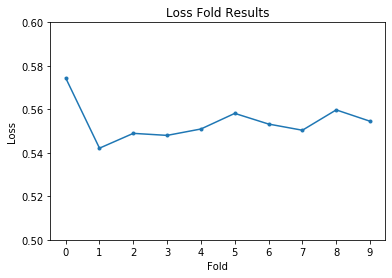

In [14]:
print(f'--------------\nFOLD SCORES\n--------------\n{pd.Series(loss_scores)}')
print(f'\n--------------\nFOLD STATS\n--------------\n{pd.Series(loss_scores).describe()}')

plt.plot(pd.Series(loss_scores).index, pd.Series(loss_scores), marker='.')
plt.title('Loss Fold Results')
plt.xlabel('Fold')
plt.xticks(np.arange(0, KFOLDS, step=1))
plt.ylabel('Loss')
plt.ylim([0.5, 0.6])
plt.show()